In [1]:
import numpy as np
import torch
import torch.utils.benchmark as benchmark
from tqdm import tqdm
import models
import matplotlib.pyplot as plt
import pandas as pd

# Static parameters

In [2]:
d_model = 768
expansion_factor = 16
n_features = d_model * expansion_factor
device = 'cuda:1'  # change to cuda:0 for single-GPU systems - second gpu is less congested

## Setup functions

In [3]:
def build_sae(d_model, n_features, dtype=torch.float, compiled=False):
    sae = models.SparseAutoEncoder(
        d_model, n_features
    )
    sae.to(device, dtype=dtype)
    
    if compiled:
        sae = torch.compile(sae)
        
    return sae

In [4]:
def build_data(batch_size, d_model, dtype=torch.float):
    data = torch.normal(
    torch.zeros((batch_size, d_model)),
    torch.ones((batch_size, d_model)),
    )

    return data.to(device, dtype=dtype)

In [5]:
def mse(x, x_hat):
    errs = (data - x_hat)**2
    per_item_errs = errs.sum(dim=1)
    return torch.mean(per_item_errs)

In [6]:
# Probably want to add optional compilation to the full step
def sae_train(sae, data, opt):
    # Reset optimizer and do fwd pass
    opt.zero_grad()
    sae_out = sae(data)
    
    # Reconstruction loss
    x_hat = sae_out['x_reconstruct']
    recon_loss = mse(data, x_hat)
    
    # L1 loss
    features = sae_out['features']
    l1_loss = torch.linalg.vector_norm(features, ord=1, dim=1)
    l1_loss = torch.mean(l1_loss)
    
    loss = recon_loss + l1_loss
    
    # Backward
    loss.backward()
    opt.step()
    
    return loss

## Training step profiling

In [7]:
batch_size_for_df = []
median_times = []
mean_times = []
dtypes = []
compileds = []

for dtype in [torch.float, torch.bfloat16]:
    for compiled in [False, True]:
        print(f'Dtype: {dtype}, compiled: {compiled}')
        sae = build_sae(d_model, n_features, dtype=dtype, compiled=compiled)
        opt = torch.optim.Adam(sae.parameters())

        min_power = 1
        max_power = 16
        num = max_power - min_power + 1
        batch_sizes = np.logspace(min_power, max_power, num=num, base=2., dtype=int)

        for batch_size in tqdm(batch_sizes):
            data = build_data(batch_size, d_model, dtype=dtype)
            t = benchmark.Timer(
                stmt='sae_train(sae, data, opt)',
                setup='from __main__ import sae_train',
                globals={'sae': sae, 'data': data, 'opt': opt},
            )
            ## Q: does blocked_autorange do a warmup (e.g. for compilation)?
            t_results = t.blocked_autorange()
            
            batch_size_for_df.append(batch_size)
            median_times.append(t_results.median)
            mean_times.append(t_results.median)
            dtypes.append(str(dtype))
            compileds.append(compiled)

Dtype: torch.float32, compiled: False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:57<00:00,  7.35s/it]


Dtype: torch.float32, compiled: True


  0%|                                                                                                                                  | 0/16 [00:00<?, ?it/s]/home/tom/projects/llama3/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:140: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:55<00:00,  7.19s/it]


Dtype: torch.bfloat16, compiled: False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.83s/it]


Dtype: torch.bfloat16, compiled: True


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.88s/it]


In [8]:
df_cols = ('batch_size', 'median_time', 'mean_time', 'dtype', 'compiled')

In [9]:
df_data = {
    'batch_size': batch_size_for_df,
    'median_time': median_times,
    'mean_time': mean_times,
    'dtype': dtypes,
    'compiled': compileds,
}

df = pd.DataFrame(data=df_data)

In [10]:
df['throughput'] = df['batch_size'] / df['mean_time']

In [11]:
def make_label(dtype, is_compiled):
    label_str = ''
    
    if dtype == 'torch.float32':
        label_str += 'float32'
        
    elif dtype == 'torch.bfloat16':
        label_str += 'bfloat16'
        
    else:
        raise ValueError('Incorrect dtype')
        
    if is_compiled:
        label_str += ', compiled'
        
    else:
        label_str += ', uncompiled'
        
    return label_str        

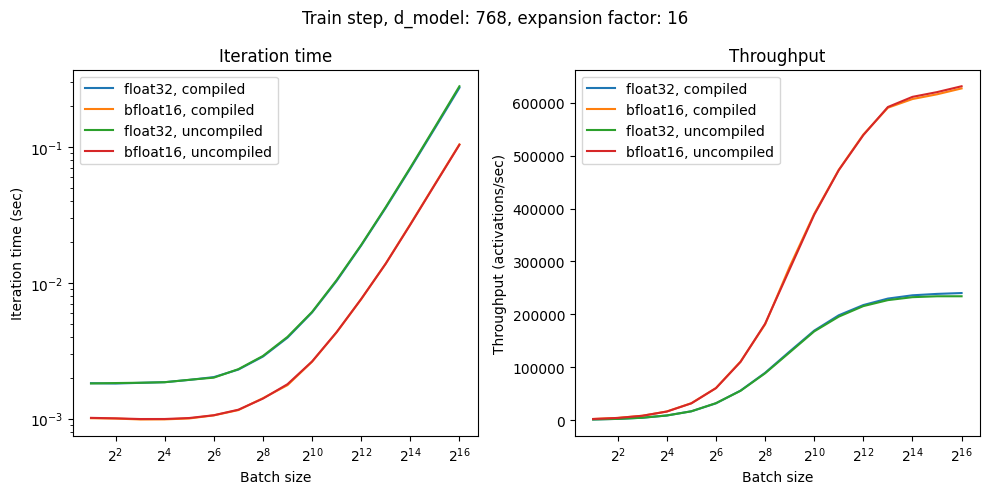

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for is_compiled in [True, False]:  # seems to be no change from compilation?
    for dtype in ['torch.float32', 'torch.bfloat16']:
        df_mask = (df['dtype'] == dtype) & (df['compiled'] == is_compiled)
        sub_df = df.loc[df_mask]
        
        # Actually plot values
        axes[0].plot(sub_df['batch_size'], sub_df['mean_time'], label=make_label(dtype, is_compiled))
        axes[1].plot(sub_df['batch_size'], sub_df['throughput'], label=make_label(dtype, is_compiled))
        
        # Iteration time labelling
        axes[0].set_xscale('log', base=2)
        axes[0].set_yscale('log')
        axes[0].set_xlabel('Batch size')
        axes[0].set_ylabel('Iteration time (sec)')
        axes[0].set_title('Iteration time')
        
        # Throughput labelling
        axes[1].set_xscale('log', base=2)
        axes[1].set_xlabel('Batch size')
        axes[1].set_ylabel('Throughput (activations/sec)')
        axes[1].set_title('Throughput')
        
fig.suptitle(f'Train step, d_model: {d_model}, expansion factor: {expansion_factor}')     
axes[0].legend()
axes[1].legend()
fig.tight_layout()
plt.show()